In [1]:
# ===========================
# Cell 0 — Config (Monolith QAE, 6q_2l_4t, tau30)
# ===========================
import numpy as np
DATA_ID = 'mackey_glass_tau30_n200'

# Architecture (6q = 2 latent + 4 trash)
wind_size = 6
wind_step = 2
n_latent = 2
n_trash = wind_size - n_latent  # = 4
n_extra = 0

# Ansatz
rot = 'Rxyz'

# Training instances
LAYER_OPTIONS = [5]
INSTANCES_PER_LAYER = [1,2,3,4,5,6,7]

# Data parameters
noise = 0.2
split = 0.75
data_low = 0
data_high = 1

# Encoding/decoding ranges
y_margin = 0.0
y_enc_low, y_enc_high = 0 + y_margin, np.pi/4 - y_margin
y_dec_low, y_dec_high = 0 + y_margin, np.pi/4 - y_margin
noise_clip = True

# Simulator settings
sim = 'lightning.qubit'
interface = 'autograd'
diff_method = 'adjoint'
shots = None

# Training parameters
n_epochs = 300
lr_initial = 0.1
lr_decay_rate = 0.75
lr_decay_steps = 60
log_interv = 1
weight_scaler = 0.1
batch_size = 10

# Seeds
TRAIN_SEED_BASE = 88000
TEST_SEED_FIXED = 99123

# Paths (relative to Monolith_QAE folder)
BUNDLE_ROOT = '../../qae_runs'

# Derived parameters
n_data = n_latent + n_trash
n_wires = n_latent + 2*n_trash + 2*n_extra

In [2]:
# ===========================
# Cell 1 — Imports & Utilities
# ===========================
import sys, os, time, random, json, csv
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint

# Add paths to find qae_utils
sys.path.append('../../..')
sys.path.append('../../../..')

# QAE utilities
from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg, ts_add_noise
from qae_utils.Charts import multi_plot_flat_ts, meas_plot
from qae_utils.Tools import draw_circuit

import pennylane as qml
from pennylane import numpy as pnp
import torch

# Create necessary folders
create_folder_if_needed(BUNDLE_ROOT)

np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (8, 4)

%matplotlib inline

def set_global_seed(instance_id: int, layer: int = None):
    """Set reproducible seeds for training instance"""
    if layer is not None:
        base = 10_000 + int(layer) * 1000 + int(instance_id)
    else:
        base = 10_000 + int(instance_id)
    
    random.seed(base + 11)
    np.random.seed(base + 22)
    try:
        pnp.random.seed(base + 33)
    except Exception:
        pass
    
    device_seed = base + 44
    
    return {
        'global_seed': base,
        'numpy_seed': base + 22,
        'pnp_seed': base + 33,
        'device_seed': device_seed
    }

def arch_tag():
    """Generate architecture tag string"""
    return f"{wind_size}q_{n_latent}l_{n_trash}t"

def x2y(x, xlim=(0, 1), ylim=(0, np.pi)):
    """Scale values from xlim range to ylim range"""
    low_x, high_x = xlim
    low_y, high_y = ylim
    input_range_length = high_x - low_x
    if np.isclose(input_range_length, 0.0):
        return (low_y + high_y) / 2
    scaling_factor = (high_y - low_y) / input_range_length
    return low_y + (x - low_x) * scaling_factor

✓ Found data at: /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/data/mackey_glass_tau30_n200
Data folder: /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/data/mackey_glass_tau30_n200
Loaded 200 samples; scale=[0.000, 1.000]


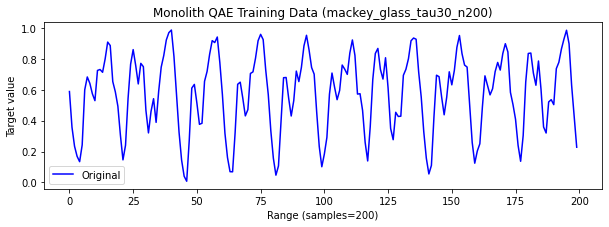

In [3]:
# ===========================
# Cell 2 — Load Data
# ===========================
def _find_data_folder(data_id):
    """Find data folder with robust path searching"""
    # Monolith notebooks: dev/Monolith_QAE/models/{dataset}/notebook.ipynb
    # Sidekick notebooks: dev/Sidekick_QAE/models/{dataset}/notebook.ipynb
    # Data location: dev/data/{dataset}/
    candidates = [
        f'../../../../data/{data_id}',  # Primary path (up 4 levels)
        f'../../../data/{data_id}',     # Alternative (up 3 levels)
        f'../../data/{data_id}',        # Alternative (up 2 levels)
    ]
    
    tried = []
    for folder in candidates:
        abs_path = os.path.abspath(folder)
        tried.append(abs_path)
        info_p = os.path.join(folder, 'info.json')
        x_p = os.path.join(folder, 'x_org.arr')
        y_p = os.path.join(folder, 'y_org.arr')
        
        if os.path.exists(info_p) and os.path.exists(x_p) and os.path.exists(y_p):
            print(f"✓ Found data at: {abs_path}")
            return folder
    
    raise FileNotFoundError(
        f"Could not find dataset: {data_id}\n"
        f"Tried paths:\n" + "\n".join(f"  - {p}" for p in tried)
    )

DATA_FOLDER = _find_data_folder(DATA_ID)
info = read_json_file(f'{DATA_FOLDER}/info.json')
X = read_ts_file(f'{DATA_FOLDER}/x_org.arr').astype(int)
y = read_ts_file(f'{DATA_FOLDER}/y_org.arr')

scale_low = float(info['scale_low'])
scale_high = float(info['scale_high'])

print(f'Data folder: {os.path.abspath(DATA_FOLDER)}')
print(f'Loaded {len(y)} samples; scale=[{scale_low:.3f}, {scale_high:.3f}]')

# Plot original data
multi_plot_flat_ts([X], [y], colors=['blue'], labels=['Original'],
                   lines=['solid'], legend_cols=1, rcParams=(10, 3),
                   xlabel=f'Range (samples={len(y)})',
                   title=f'Monolith QAE Training Data ({DATA_ID})')

In [4]:
# ===========================
# Cell 3 — Full QAE Architecture
# ===========================
def full_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Rxyz'):
    """Calculate weight shape for full QAE"""
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    elif rot == 'Rxyz':
        return qml.StronglyEntanglingLayers.shape(n_layers=n_layers*2, n_wires=n_wires)

def full_qae(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Rxyz', 
             add_outseq=False, invert_dec=True):
    """
    Create full QAE circuit with SWAP-based reset
    Returns: QNode-compatible callable
    """
    n_data = n_latent + n_trash
    n_anz = n_data + n_extra
    n_zero = n_trash + n_extra
    
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    extra_wires = wires[n_data:n_data+n_extra]
    zero_wires = wires[n_anz:n_anz+n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires + extra_wires

    def _sequence_encoder(wires, inputs):
        """Angle embedding of input sequence"""
        qml.AngleEmbedding(inputs, wires=wires, rotation='Y')

    def _entangler_shape(n_layers, n_wires, rot='Rxyz'):
        """Get shape for entangling layer"""
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

    def _entangler(wires, weights, rot='Rxyz'):
        """Apply entangling layers"""
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=wires)

    def _swap(from_wires, to_wires):
        """Apply SWAP gates"""
        for i in range(len(from_wires)):
            qml.SWAP(wires=[from_wires[i], to_wires[i]])

    def _full_qae(weights, inputs):
        """Full QAE circuit"""
        # Input encoding
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        # Get weight shapes
        enc_weights_shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        dec_weights_shape = enc_weights_shape

        # Split weights
        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        # Encoder
        _entangler(anz_wires, enc_weights, rot=rot)

        # SWAP reset
        qml.Barrier(wires)
        _swap(trash_wires + extra_wires, zero_wires)
        qml.Barrier(wires)

        # Decoder
        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        else:
            _entangler(anz_wires, enc_weights, rot=rot)
        qml.Barrier(wires)

        # Optional output sequence
        if add_outseq:
            qml.adjoint(_sequence_encoder)(data_wires, inputs)

        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]

    return _full_qae

shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers=1, rot=rot)
print(f'Base QAE shape (per layer): {shape}')
print(f'Architecture: {arch_tag()}')

Base QAE shape (per layer): (2, 6, 3)
Architecture: 6q_2l_4t


In [5]:
# ===========================
# Cell 4 — Training Functions
# ===========================
def get_mini_batches(W_noisy, W_clean, batch_size=10, shuffle=True, seed=0):
    """Generate mini-batches for training"""
    if seed == 0:
        seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    num_samples = W_clean.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        yield W_noisy[batch_indices], W_clean[batch_indices]

def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, 
                   range_low=0.2, range_high=0.8, seed=0, noise_clip=True):
    """Create sliding window tensors with optional noise"""
    y_noisy = ts_add_noise(y, noise=noise, noise_type='normal', clip=noise_clip,
                          range_low=range_low, range_high=range_high, seed=seed)
    y_ts = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = ts_wind_make(X, wind_size, wind_step)
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)
    
    X_train_tens = pnp.array(X_train_ts, requires_grad=False)
    y_train_tens = pnp.array(y_train_ts, requires_grad=False)
    X_test_tens = pnp.array(X_test_ts, requires_grad=False)
    y_test_tens = pnp.array(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

def mse_cost_on_tensors(targets, predictions):
    """MSE cost function (gradient-friendly)"""
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    return cost / vals

def cost_fun_gen_on_tensors(model, cost_fun):
    """Generate cost function for model"""
    def _cost_fun(params, inputs, targets):
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

def train_with_noise(model, W, cost_fun, optimizer, n_epochs, init_weights=None,
                     log_interv=1, prompt_fract=0.1, start_time=0, seed=0,
                     wind_size=8, wind_step=4, noise=0, 
                     enc_lim=(0, 1), dec_lim=(0, 1)):
    """Train model with noisy mini-batches"""
    enc_low, enc_high = enc_lim
    dec_low, dec_high = dec_lim
    
    if seed == 0:
        seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    hist_cost = []
    hist_params = []
    params = init_weights.copy()
    
    # Prepare pure targets
    _, y_pure, _, _ = create_sw_tens(W, W, noise=0, wind_size=wind_size, 
                                     wind_step=wind_step, range_low=enc_low, 
                                     range_high=enc_high)
    y_pure = x2y(y_pure, xlim=(enc_low, enc_high), ylim=(dec_low, dec_high))
    
    if start_time == 0:
        start_time = time.time()
    
    for iter in range(n_epochs):
        # Generate noisy inputs
        _, X_noisy, _, _ = create_sw_tens(W, W, noise=noise, seed=seed+iter,
                                          noise_clip=noise_clip, wind_size=wind_size,
                                          wind_step=wind_step, range_low=enc_low,
                                          range_high=enc_high)
        
        # Decay learning rate
        if (iter+1) % lr_decay_steps == 0:
            optimizer.stepsize *= lr_decay_rate
        
        # Mini-batch training
        batches = get_mini_batches(X_noisy, y_pure, batch_size=batch_size, 
                                   shuffle=True, seed=seed+iter)
        acc_batch_cost = 0
        for batch_no, (noisy_batch, pure_batch) in enumerate(batches):
            params, batch_cost = optimizer.step_and_cost(
                lambda p: cost_fun(p, noisy_batch, pure_batch), params)
            acc_batch_cost += batch_cost
        cost = acc_batch_cost / (batch_no + 1)
        
        # Logging
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        
        if (prompt_fract > 0) and (iter % int(prompt_fract*n_epochs) == 0):
            elapsed = int(time.time() - start_time)
            print(f'Iter: {iter:03d} ({elapsed:04d} sec) cost={cost:0.6f}, ' +
                  f'min={np.min(hist_cost):0.6f} (LR={optimizer.stepsize:0.4f})')
    
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    elapsed = int(time.time() - start_time)
    print(f'\nCompleted: epochs={n_epochs}, min cost={min_cost:.6f} @ {min_iter}, ' +
          f'time={elapsed} sec\n')
    
    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed)

In [6]:
# ===========================
# Cell 5 — Evaluation Functions
# ===========================
def _flatten_avg(windows):
    """Flatten overlapping windows by averaging"""
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def _mse(a, b):
    """Calculate MSE between two sequences"""
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

def windows_from_seed(y_vec, sigma, seed, clip=True):
    """Generate clean and noisy windows with fixed seed"""
    y_noisy = ts_add_noise(y_vec, noise=sigma, noise_type='normal', clip=clip,
                          range_low=scale_low, range_high=scale_high, seed=seed)
    win_clean = ts_wind_make(y_vec, wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return tr_clean, tr_noisy, te_clean, te_noisy

def run_qnode_series(model, params, windows):
    """Run model on series of windows"""
    outs = []
    for w in windows:
        z = model(params, w)
        outs.append(np.asarray(z))
    return np.stack(outs)

def render_circuit(L, weights_vec, save_dir, inst, seed=None):
    """Render and save circuit diagram"""
    wires = list(range(n_wires))
    qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=L, 
                   rot=rot, add_outseq=False, invert_dec=True)
    
    if seed is not None:
        dev = qml.device(sim, wires=n_wires, shots=shots, seed=seed)
    else:
        dev = qml.device(sim, wires=n_wires, shots=shots)
    
    qnode = qml.QNode(qae, dev)
    
    x_dummy = np.zeros(wind_size, dtype=float)
    qml.drawer.use_style("pennylane")
    fig_func = qml.draw_mpl(qnode, decimals=2, level="device")
    fig, ax = fig_func(weights_vec, x_dummy)
    ax.set_title(f'Monolith QAE (L={L}, inst={inst})')
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    out_eps = save_dir / f"circuit_{arch_tag()}_L{L}_inst{inst:02d}.eps"
    fig.savefig(out_eps, dpi=220, bbox_inches="tight", pad_inches=0.1, format="eps")
    plt.close(fig)
    return out_eps

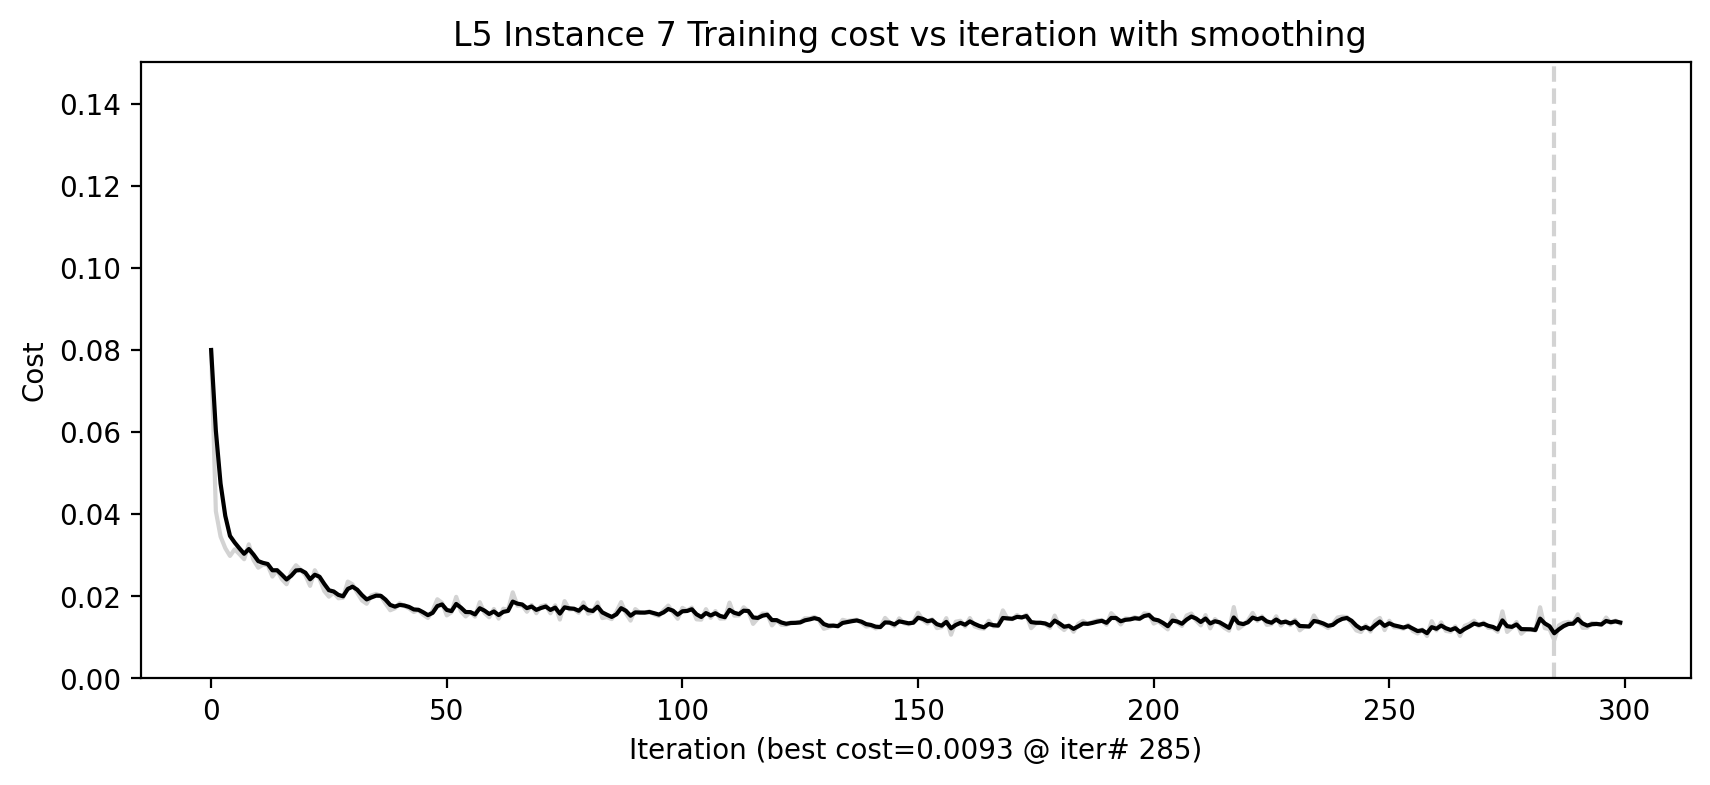

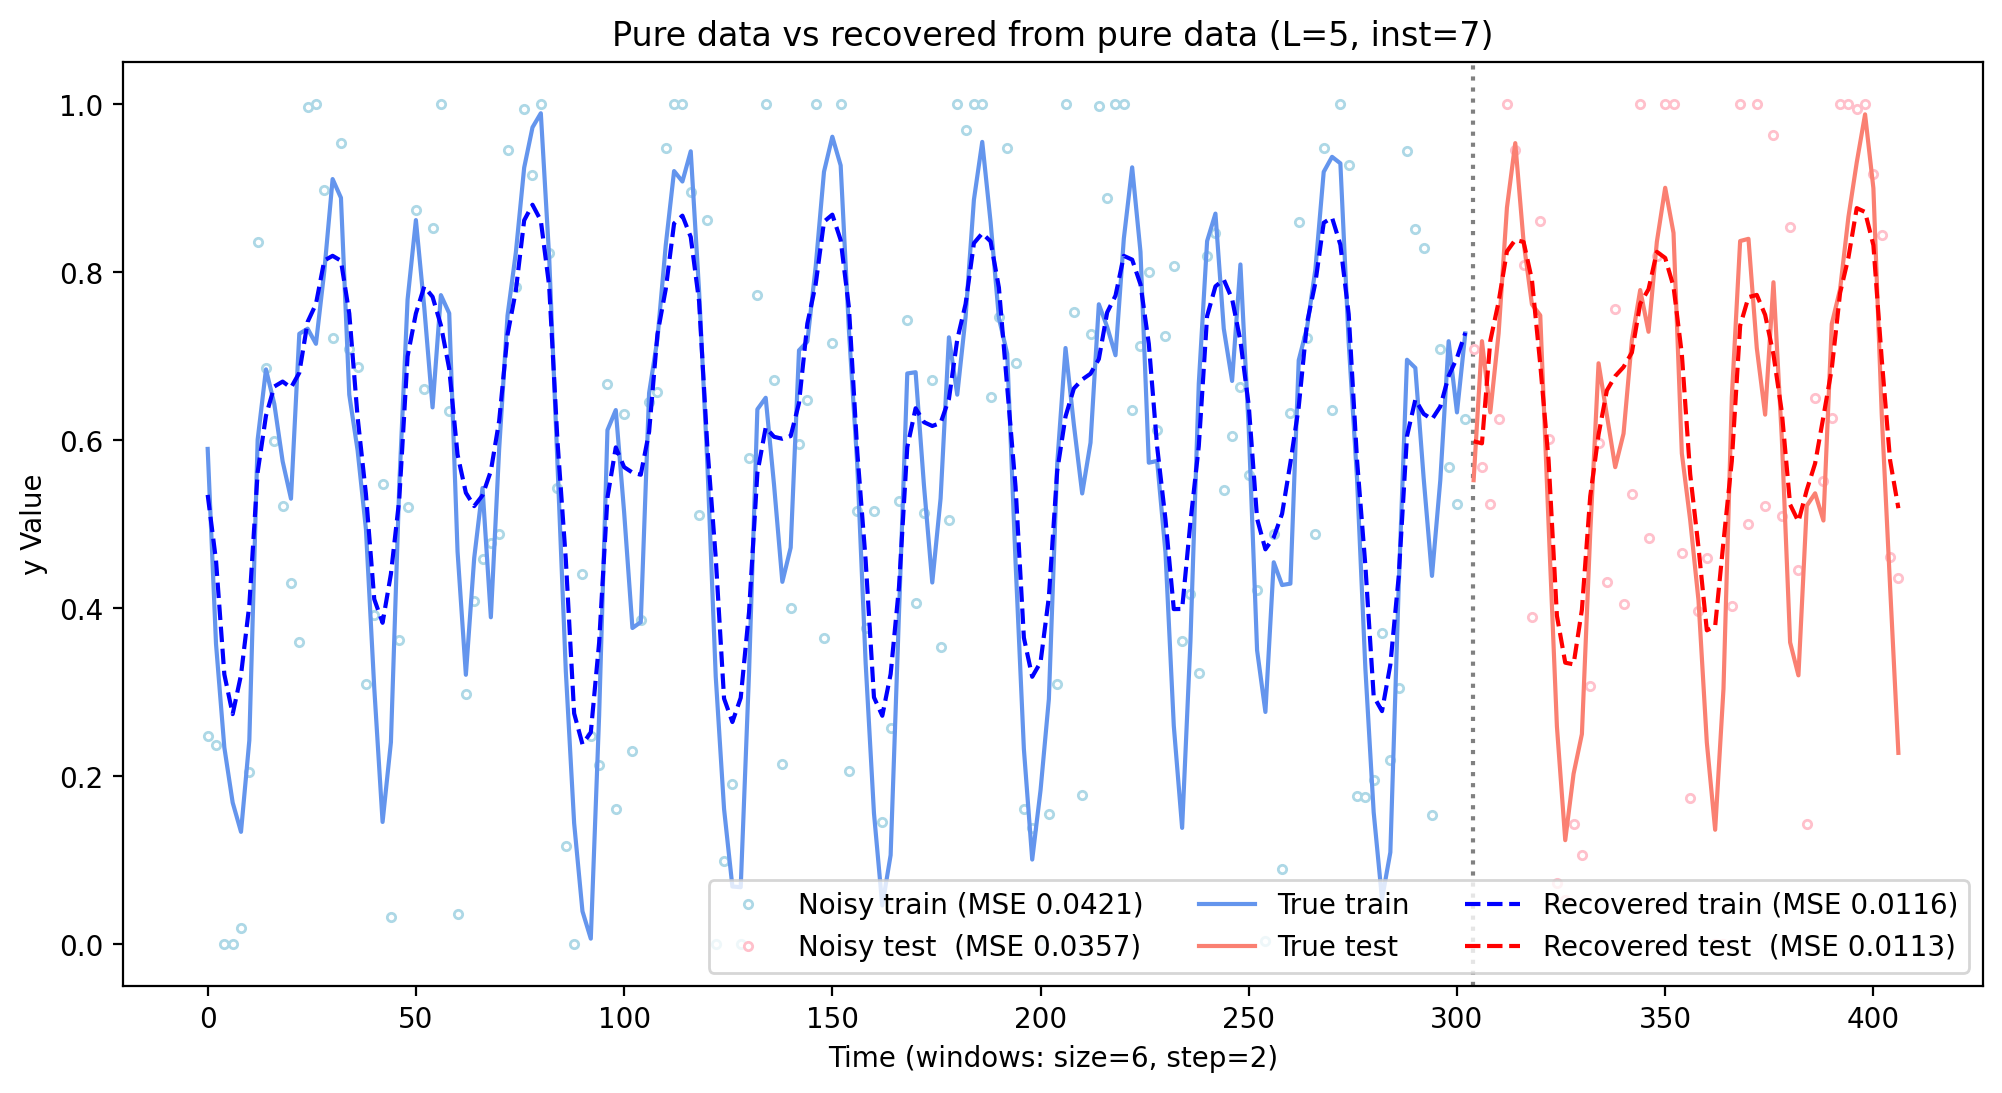

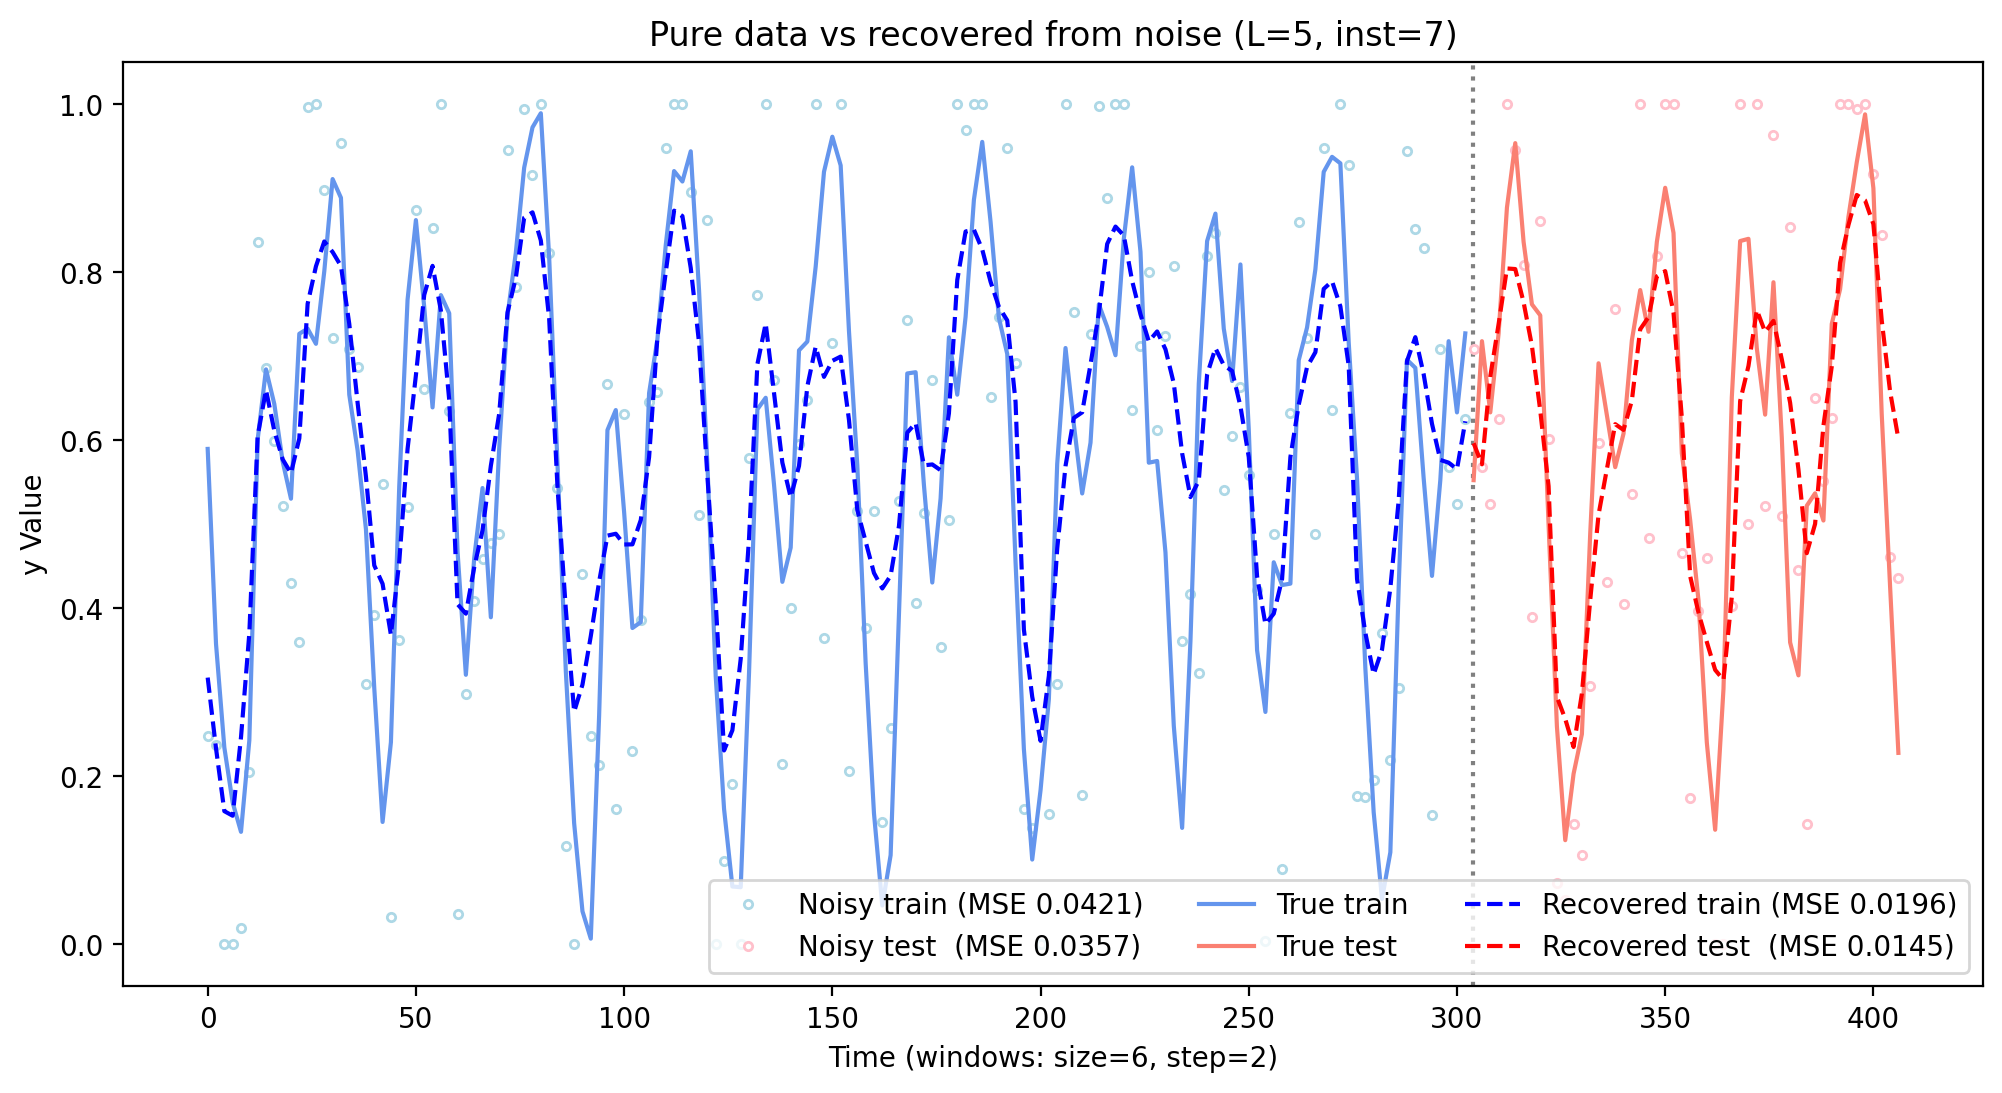


TRAINING COMPLETE
Metrics saved: ../../qae_runs/mackey_glass_tau30_n200/6q_2l_4t/metrics_by_run.csv
Artifacts saved: ../../qae_runs/mackey_glass_tau30_n200/6q_2l_4t

Summary saved: ../../qae_runs/mackey_glass_tau30_n200/6q_2l_4t/summary_by_layer.csv
       runs  avg_training_time  mse_test_noise_mean  mse_test_recovered_mean  \
layer                                                                          
1         7         111.285714             0.035742                 0.034676   
2         7         195.714286             0.035742                 0.019151   
3         7         262.142857             0.035742                 0.022236   
4         7         326.428571             0.035742                 0.015116   
5         7         400.714286             0.035742                 0.012999   

       delta_test_pct_mean  
layer                       
1                 2.983690  
2                46.420111  
3                37.786598  
4                57.707041  
5             

In [7]:
# ===========================
# Cell 6 — Multi-Instance Training
# ===========================
import pandas as pd

def ensure_dir(p):
    """Create directory if it doesn't exist"""
    p = Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p

# Setup directory structure
ROOT = ensure_dir(BUNDLE_ROOT)
DATA_ROOT = ensure_dir(ROOT / DATA_ID)
ARCH_ROOT = ensure_dir(DATA_ROOT / arch_tag())
CSV_RUNS = ARCH_ROOT / "metrics_by_run.csv"
CSV_SUMMARY = ARCH_ROOT / "summary_by_layer.csv"

RUNS_HEADER = [
    "dataset", "arch", "instance_id", "layer",
    "window_size", "step", "sigma_eval",
    "mse_train_noise", "mse_train_recovered", "delta_train_pct",
    "mse_test_noise", "mse_test_recovered", "delta_test_pct",
    "min_train_cost", "training_time_sec", "timestamp", "bundle_json"
]

if not CSV_RUNS.exists():
    with open(CSV_RUNS, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow(RUNS_HEADER)

ALL_RUNS = []

for L in LAYER_OPTIONS:
    print(f"\n{'='*60}")
    print(f"TRAINING LAYER {L}")
    print(f"{'='*60}")
    
    # Get shape for this layer count
    shp = full_qae_shape(n_latent, n_trash, n_extra, n_layers=L, rot=rot)
    
    layer_dir = ensure_dir(ARCH_ROOT / f"L{L}")
    
    for inst in INSTANCES_PER_LAYER:
        print(f"\n{'─'*60}")
        print(f"Layer {L} | Instance {inst}")
        print(f"{'─'*60}")
        
        # Set seed with layer parameter
        seed_info = set_global_seed(inst, layer=L)
        device_seed = seed_info['device_seed']
        print(f"Seeds: global={seed_info['global_seed']}, device={device_seed}")

        # Create device with seed
        wires = list(range(n_wires))
        dev = qml.device(sim, wires=n_wires, shots=shots, seed=device_seed)
        qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=L,
                       rot=rot, add_outseq=False, invert_dec=True)
        qae_model = qml.QNode(qae, dev, interface=interface, diff_method=diff_method)
        qae_model.shape = shp
        
        # Initialize optimizer and weights
        opt = qml.AdamOptimizer(stepsize=lr_initial, beta1=0.99)
        init_weights = pnp.array(np.random.uniform(high=2*np.pi, size=shp) * weight_scaler, 
                                 requires_grad=True)
        
        # Define cost function
        cost_fun = cost_fun_gen_on_tensors(qae_model, mse_cost_on_tensors)
        
        # Prepare encoded data
        y_enc = x2y(y, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
        
        # Train
        hist_cost, hist_params, _, (min_iter, min_cost, elapsed) = train_with_noise(
            qae_model, y_enc, cost_fun, opt, n_epochs, init_weights,
            log_interv=log_interv, prompt_fract=0.1, seed=TRAIN_SEED_BASE,
            wind_size=wind_size, wind_step=wind_step, noise=noise,
            enc_lim=(y_enc_low, y_enc_high), dec_lim=(y_dec_low, y_dec_high)
        )
        
        # Get optimal parameters
        opt_params = hist_params[min_iter]
        weights_np = np.array(opt_params)
        
        # Evaluate on test set
        tr_c, tr_n, te_c, te_n = windows_from_seed(y, noise, TEST_SEED_FIXED, clip=True)
        tr_n_enc = x2y(tr_n, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
        te_n_enc = x2y(te_n, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
        
        tr_hat = run_qnode_series(qae_model, opt_params, tr_n_enc)
        te_hat = run_qnode_series(qae_model, opt_params, te_n_enc)
        
        # Also evaluate from pure data
        tr_c_enc = x2y(tr_c, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
        te_c_enc = x2y(te_c, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
        tr_hat_pure = run_qnode_series(qae_model, opt_params, tr_c_enc)
        te_hat_pure = run_qnode_series(qae_model, opt_params, te_c_enc)
        
        # Flatten all for metrics and plotting
        tr_pure = _flatten_avg(tr_c); te_pure = _flatten_avg(te_c)
        tr_noi = _flatten_avg(tr_n); te_noi = _flatten_avg(te_n)
        tr_rec = x2y(_flatten_avg(tr_hat), xlim=(y_dec_low, y_dec_high), 
                     ylim=(scale_low, scale_high))
        te_rec = x2y(_flatten_avg(te_hat), xlim=(y_dec_low, y_dec_high), 
                     ylim=(scale_low, scale_high))
        tr_rec_pure = x2y(_flatten_avg(tr_hat_pure), xlim=(y_dec_low, y_dec_high), 
                          ylim=(scale_low, scale_high))
        te_rec_pure = x2y(_flatten_avg(te_hat_pure), xlim=(y_dec_low, y_dec_high), 
                          ylim=(scale_low, scale_high))
        
        # Create coordinate arrays
        n_train = len(tr_pure)
        n_test = len(te_pure)
        X_coords_train = np.arange(0, n_train * wind_step, wind_step)[:n_train]
        X_coords_test = np.arange(n_train * wind_step, 
                                  n_train * wind_step + n_test * wind_step, 
                                  wind_step)[:n_test]
        
        # Calculate metrics
        mse_tr_noise = _mse(tr_pure, tr_noi)
        mse_te_noise = _mse(te_pure, te_noi)
        mse_tr_rec = _mse(tr_pure, tr_rec)
        mse_te_rec = _mse(te_pure, te_rec)
        mse_tr_rec_pure = _mse(tr_pure, tr_rec_pure)
        mse_te_rec_pure = _mse(te_pure, te_rec_pure)
        
        delta_tr = 100.0 * (1.0 - mse_tr_rec / max(mse_tr_noise, 1e-12))
        delta_te = 100.0 * (1.0 - mse_te_rec / max(mse_te_noise, 1e-12))
        
        print(f"Test MSE: noise={mse_te_noise:.6f}, recovered={mse_te_rec:.6f}, Δ={delta_te:+.2f}%")
        
        # Save artifacts
        inst_tag = f"inst{inst:02d}_L{L}"
        np.save(layer_dir / f"weights_{inst_tag}.npy", weights_np)

        # Pass device_seed to render function
        circuit_path = render_circuit(L, weights_np, ARCH_ROOT, inst, seed=device_seed)
        
        # Plot training cost
        cost_plot_path = layer_dir / f"training_cost_{inst_tag}.eps"
        meas_plot(hist_cost, meas='cost', task='min', 
                  title_pref=f'L{L} Instance {inst} Training', 
                  ylim=(0, max(0.15, max(hist_cost)*1.1)), rcParams=(10, 4), 
                  log_interv=log_interv, backplot=True, back_color='lightgray', 
                  smooth_weight=0.5, save_plot=cost_plot_path)
        
        # Save cost history
        cost_path = layer_dir / f"cost_{inst_tag}.json"
        with open(cost_path, "w", encoding="utf-8") as f:
            json.dump([float(cost) for cost in hist_cost], f, indent=2)

        # Plot reconstruction from pure data
        recon_pure_path = layer_dir / f"reconstruction_pure_{inst_tag}.eps"
        multi_plot_flat_ts(
            X_list=[X_coords_train, X_coords_test, X_coords_train, X_coords_test, X_coords_train, X_coords_test],
            y_list=[tr_noi, te_noi, tr_pure, te_pure, tr_rec_pure, te_rec_pure],
            labels=[f"Noisy train (MSE {mse_tr_noise:0.4f})", 
                    f"Noisy test  (MSE {mse_te_noise:0.4f})", 
                    "True train", "True test",
                    f"Recovered train (MSE {mse_tr_rec_pure:0.4f})", 
                    f"Recovered test  (MSE {mse_te_rec_pure:0.4f})"],
            vert_lines=['', 'dotted', '', '', '', ''], vert_line_color='gray',
            colors=['lightblue', 'pink', 'cornflowerblue', 'salmon', 'blue', 'red'],
            marker_colors=['white', 'white', 'lightblue', 'mistyrose', 'blue', 'red'],
            lines=['', '', 'solid', 'solid', 'dashed', 'dashed'],
            markers=['.', '.', '', '', '', ''],
            rcParams=(12, 6), dpi=200,
            xlabel=f'Time (windows: size={wind_size}, step={wind_step})', ylabel='y Value',
            legend_cols=3, title=f"Pure data vs recovered from pure data (L={L}, inst={inst})",
            save_plot=recon_pure_path)
        
        # Plot reconstruction from noisy data
        recon_noisy_path = layer_dir / f"reconstruction_noisy_{inst_tag}.eps"
        multi_plot_flat_ts(
            X_list=[X_coords_train, X_coords_test, X_coords_train, X_coords_test, X_coords_train, X_coords_test],
            y_list=[tr_noi, te_noi, tr_pure, te_pure, tr_rec, te_rec],
            labels=[f"Noisy train (MSE {mse_tr_noise:0.4f})", 
                    f"Noisy test  (MSE {mse_te_noise:0.4f})", 
                    "True train", "True test",
                    f"Recovered train (MSE {mse_tr_rec:0.4f})", 
                    f"Recovered test  (MSE {mse_te_rec:0.4f})"],
            vert_lines=['', 'dotted', '', '', '', ''], vert_line_color='gray',
            colors=['lightblue', 'pink', 'cornflowerblue', 'salmon', 'blue', 'red'],
            marker_colors=['white', 'white', 'lightblue', 'mistyrose', 'blue', 'red'],
            lines=['', '', 'solid', 'solid', 'dashed', 'dashed'],
            markers=['.', '.', '', '', '', ''],
            rcParams=(12, 6), dpi=200,
            xlabel=f'Time (windows: size={wind_size}, step={wind_step})', ylabel='y Value',
            legend_cols=3, title=f"Pure data vs recovered from noise (L={L}, inst={inst})",
            save_plot=recon_noisy_path)
        
        # Create bundle
        bundle = {
            "schema": {"name": "monolith_qae_bundle", "version": "1.0"},
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": {
                "id": DATA_ID,
                "scale_low": float(scale_low),
                "scale_high": float(scale_high),
                "window_size": int(wind_size),
                "window_step": int(wind_step),
                "split": float(split),
            },
            "run": {
                "instance_id": int(inst),
                "layer": int(L),
                "sigma_eval": float(noise),
                "test_seed_fixed": int(TEST_SEED_FIXED),
                "device_seed": int(device_seed),
                "training_time_sec": int(elapsed),
            },
            "environment": {
                "device": sim,
                "diff_method": diff_method,
                "interface": interface,
            },
            "architecture": {
                "type": "monolith",
                "n_qubits": int(wind_size),
                "n_latent": int(n_latent),
                "n_trash": int(n_trash),
                "n_extra": int(n_extra),
                "rot": str(rot),
            },
            "parameters": {
                "weights": weights_np.tolist(),
            },
            "metrics": {
                "mse_train_noise": float(mse_tr_noise),
                "mse_train_recovered": float(mse_tr_rec),
                "delta_train_pct": float(delta_tr),
                "mse_test_noise": float(mse_te_noise),
                "mse_test_recovered": float(mse_te_rec),
                "delta_test_pct": float(delta_te),
                "mse_train_recovered_pure": float(mse_tr_rec_pure),
                "mse_test_recovered_pure": float(mse_te_rec_pure),
                "min_train_cost": float(min_cost),
            },
            "artifacts": {
                "weights_file": f"weights_{inst_tag}.npy",
                "circuit_diagram": str(circuit_path.name),
                "training_cost_plot": str(cost_plot_path.name),
                "cost_history": str(cost_path.name),
                "reconstruction_pure_plot": str(recon_pure_path.name),
                "reconstruction_noisy_plot": str(recon_noisy_path.name),
            }
        }
        
        bundle_path = layer_dir / f"bundle_{inst_tag}.json"
        with open(bundle_path, "w", encoding="utf-8") as f:
            json.dump(bundle, f, indent=2)
        
        # Save to CSV
        row = [
            DATA_ID, arch_tag(), int(inst), int(L),
            int(wind_size), int(wind_step), float(noise),
            mse_tr_noise, mse_tr_rec, delta_tr,
            mse_te_noise, mse_te_rec, delta_te,
            float(min_cost), int(elapsed), bundle["timestamp"], str(bundle_path)
        ]
        
        if CSV_RUNS.exists():
            df_old = pd.read_csv(CSV_RUNS)
            df_new = pd.concat([df_old, pd.DataFrame([row], columns=RUNS_HEADER)], 
                              ignore_index=True)
            df_new.to_csv(CSV_RUNS, index=False)
        else:
            pd.DataFrame([row], columns=RUNS_HEADER).to_csv(CSV_RUNS, index=False)
        
        ALL_RUNS.append({"instance_id": inst, "layer": L, "weights": weights_np})

print(f"\n{'='*60}")
print(f"TRAINING COMPLETE")
print(f"Metrics saved: {CSV_RUNS}")
print(f"Artifacts saved: {ARCH_ROOT}")
print(f"{'='*60}")

# Generate summary
if CSV_RUNS.exists():
    df = pd.read_csv(CSV_RUNS)
    summary = (df.groupby("layer", as_index=True)
               .agg(runs=("instance_id", "count"),
                    avg_training_time=("training_time_sec", "mean"),
                    mse_test_noise_mean=("mse_test_noise", "mean"),
                    mse_test_recovered_mean=("mse_test_recovered", "mean"),
                    delta_test_pct_mean=("delta_test_pct", "mean")))
    summary.to_csv(CSV_SUMMARY)
    print(f"\nSummary saved: {CSV_SUMMARY}")
    print(summary)

# Software in use (Linux)

In [8]:
import os
os.system('pip list | grep -e pennylane -e torch');

pennylane                 0.42.3
pennylane_lightning       0.42.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
